<a href="https://colab.research.google.com/github/wabinyai/spatia-model/blob/main/Predicting_missing_pm2_5_for_parishes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install geopandas gpflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.7/376.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 12.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime  as dt
import requests
import pytz

In [3]:
import geopandas as gpd
import folium
import branca.colormap as cm

In [4]:
import requests
from folium.plugins import MarkerCluster

Using data export feature from https://platform.airqo.net/download export by airqloud

In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving airquality-data2.csv to airquality-data2 (1).csv
User uploaded file "airquality-data2.csv" with length 261703 bytes


In [8]:
data = pd.read_csv(fn)
data.head(3)

,device_latitude,device_longitude,device_name,pm2_5_raw_value,pm2_5_calibrated_value,pm10_calibrated_value,pm10_raw_value,datetime,tenant,site_id,site_name,site_latitude,site_longitude,device_name_1,frequency
0,0.2336,32.5635,aq_48,7.71,NaN,NaN,8.28,5/9/2023 2:00,airqo,60d058c8048305120d2d6157,"Seguku, Makindye-Ssabagabo",0.232475,32.567848,aq_48,hourly
1,0.2336,32.5635,aq_48,5.53,7.24,NaN,5.93,5/9/2023 3:00,airqo,60d058c8048305120d2d6157,"Seguku, Makindye-Ssabagabo",0.232475,32.567848,aq_48,hourly
2,0.2336,32.5635,aq_48,7.19,6.75,NaN,7.66,5/9/2023 4:00,airqo,60d058c8048305120d2d6157,"Seguku, Makindye-Ssabagabo",0.232475,32.567848,aq_48,hourly


In [9]:
data=data.dropna(subset='pm2_5_calibrated_value')
data.head(2)

,device_latitude,device_longitude,device_name,pm2_5_raw_value,pm2_5_calibrated_value,pm10_calibrated_value,pm10_raw_value,datetime,tenant,site_id,site_name,site_latitude,site_longitude,device_name_1,frequency
1,0.2336,32.5635,aq_48,5.53,7.24,NaN,5.93,5/9/2023 3:00,airqo,60d058c8048305120d2d6157,"Seguku, Makindye-Ssabagabo",0.232475,32.567848,aq_48,hourly
2,0.2336,32.5635,aq_48,7.19,6.75,NaN,7.66,5/9/2023 4:00,airqo,60d058c8048305120d2d6157,"Seguku, Makindye-Ssabagabo",0.232475,32.567848,aq_48,hourly


Shape file for Uganda using ADMIN level 5, In Uganda that is parish level

In [11]:
from google.colab import files

uploaded = files.upload()

for fnn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fnn, length=len(uploaded[fnn])))

Saving stanford-hb557fg0018-shapefile.zip to stanford-hb557fg0018-shapefile.zip
User uploaded file "stanford-hb557fg0018-shapefile.zip" with length 18442994 bytes


In [12]:
df_p = gpd.read_file(fnn)
df_p.head()

,dname_2002,d_02_id,cname_2002,c_02_id,sname_2002,s_02_id,pname_2002,p_02_id,ftype,label_p,...,p_06_id,area,perimeter,hectares,dname_2010,sname_2010,subregion,pname_2010,country,geometry
0,KALANGALA,101,KYAMUSWA,1012,BUBEKE,101201,JAANA,10120102.0,Populated Area,Jaana,...,10120100.0,3693259.121,13322.878,369.326,KALANGALA,BUBEKE,CENTRAL 1,JAANA,UGANDA,"POLYGON ((32.58384 -0.21551, 32.58429 -0.21564..."
1,KAMPALA,102,KAMPALA CITY COUNCIL,1021,CENTRAL DIVISION,102101,KOLOLO I,10210110.0,Populated Area,Kololo I,...,10210100.0,1156934.016,6488.074,115.693,KAMPALA,CENTRAL DIVISION,CENTRAL 1,KOLOLO I,UGANDA,"POLYGON ((32.59492 0.34412, 32.59499 0.34416, ..."
2,KAMPALA,102,KAMPALA CITY COUNCIL,1021,CENTRAL DIVISION,102101,KOLOLO II,10210111.0,Populated Area,Kololo II,...,10210100.0,1068686.625,4347.292,106.869,KAMPALA,CENTRAL DIVISION,CENTRAL 1,KOLOLO II,UGANDA,"POLYGON ((32.58950 0.34222, 32.58908 0.34118, ..."
3,KAMPALA,102,KAMPALA CITY COUNCIL,1021,CENTRAL DIVISION,102101,KOLOLO III,10210112.0,Populated Area,Kololo III,...,10210100.0,928639.703,4388.508,92.864,KAMPALA,CENTRAL DIVISION,CENTRAL 1,KOLOLO III,UGANDA,"POLYGON ((32.58581 0.34034, 32.58576 0.34030, ..."
4,KAMPALA,102,KAMPALA CITY COUNCIL,1021,CENTRAL DIVISION,102101,OLD KAMPALA,10210120.0,Populated Area,Old Kampala,...,10210100.0,579810.344,3661.548,57.981,KAMPALA,CENTRAL DIVISION,CENTRAL 1,OLD KAMPALA,UGANDA,"POLYGON ((32.57083 0.32424, 32.57084 0.32402, ..."


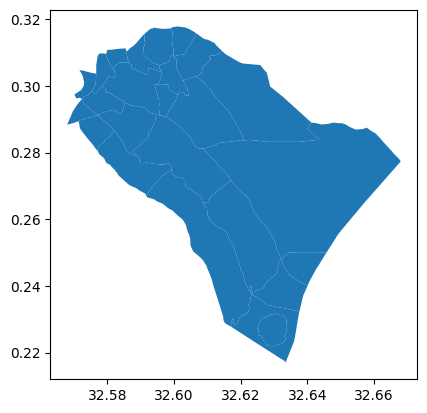

In [14]:
#jinja= df_p[df_p.dname_2002 =='KAMPALA']  # filter down the dataframe to only those rows that have the "kampala" column equal to "Kampala" and extract the
jinja= df_p[(df_p.dname_2002 =='KAMPALA')&(df_p.sname_2010 =='MAKINDYE DIVISION')] 
#jinja.crs = {'init': 'epsg:4326'}  # set the coordinate reference system as WGS 84  (long
#jinja
#jinja= df_p[(df_p.ADM2_EN =='Kampala')]
jinja.plot()
plt.show()

In [15]:
jan_filtered_df = data.groupby(["site_name"])["pm2_5_calibrated_value","site_latitude","site_longitude"].mean().round(2)
jan_filtered_df=jan_filtered_df.reset_index().sort_values(by='pm2_5_calibrated_value',ascending=False)
jan_filtered_df

<ipython-input-15-b661e3bbee69>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  jan_filtered_df = data.groupby(["site_name"])["pm2_5_calibrated_value","site_latitude","site_longitude"].mean().round(2)


,site_name,pm2_5_calibrated_value,site_latitude,site_longitude
2,"Katwe 1, Makindye",34.25,0.30,32.58
5,Makindye Kcca division offices,34.17,0.29,32.58
3,"Kibuli, Makindye",29.26,0.31,32.59
1,"Kabalagala town, Makindye",28.35,0.30,32.60
0,"Ggaba, Makindye",25.91,0.26,32.64
6,"Makindye, Lukuli Makindye",17.82,0.28,32.59
9,"St.Ponsiano primary school, makindye",17.17,0.26,32.61
4,"Kizungu, Makindye",13.73,0.28,32.59
7,"Muyenga tank hill, Makindye",11.52,0.30,32.61
8,"Seguku, Makindye-Ssabagabo",7.67,0.23,32.57


In [16]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import os
# Create a list of Point objects from the longitude and latitude columns
points = [Point(xy) for xy in zip(jan_filtered_df['site_longitude'], jan_filtered_df['site_latitude'])]

# Create a GeoDataFrame from the points and the original dataframe
geo_df = gpd.GeoDataFrame(jan_filtered_df, geometry=points)

# Print the GeoDataFrame
print(geo_df.head())


                        site_name  pm2_5_calibrated_value  site_latitude  \
2               Katwe 1, Makindye                   34.25           0.30   
5  Makindye Kcca division offices                   34.17           0.29   
3                Kibuli, Makindye                   29.26           0.31   
1       Kabalagala town, Makindye                   28.35           0.30   
0                 Ggaba, Makindye                   25.91           0.26   

   site_longitude                  geometry  
2           32.58  POINT (32.58000 0.30000)  
5           32.58  POINT (32.58000 0.29000)  
3           32.59  POINT (32.59000 0.31000)  
1           32.60  POINT (32.60000 0.30000)  
0           32.64  POINT (32.64000 0.26000)  


In [17]:
merged = gpd.sjoin(jinja,geo_df, how='left', op='contains', lsuffix='_polygon', rsuffix='_point')


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-17-71739436dff3>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...
Right CRS: None

  merged = gpd.sjoin(jinja,geo_df, how='left', op='contains', lsuffix='_polygon', rsuffix='_point')


In [18]:
merged[['pname_2010','pm2_5_calibrated_value',"hectares", "p_02_id",'geometry']]

,pname_2010,pm2_5_calibrated_value,hectares,p_02_id,geometry
45,WABIGALO,NaN,55.924,10210315.0,"POLYGON ((32.60664 0.31582, 32.60640 0.31535, ..."
46,KIBULI,NaN,102.271,10210306.0,"POLYGON ((32.59892 0.31726, 32.59931 0.31667, ..."
47,KISUGU,NaN,122.739,10210309.0,"POLYGON ((32.61229 0.31282, 32.61237 0.31261, ..."
48,NSAMBYA POLICE BARRACKS,29.26,64.106,10210321.0,"POLYGON ((32.59121 0.31563, 32.59133 0.31537, ..."
49,NSAMBYA RAILWAY,NaN,33.396,10210313.0,"POLYGON ((32.58585 0.31031, 32.58576 0.31011, ..."
50,BUKASA,11.52,610.936,10210301.0,"POLYGON ((32.62727 0.30468, 32.62726 0.30465, ..."
51,KATWE II,NaN,50.333,10210305.0,"POLYGON ((32.57944 0.30969, 32.57964 0.30912, ..."
52,KABALAGALA,28.35,67.697,10210303.0,"POLYGON ((32.60006 0.30890, 32.59995 0.30876, ..."
53,NSAMBYA CENTRAL,34.25,204.995,10210319.0,"POLYGON ((32.58640 0.30697, 32.58674 0.30676, ..."
54,KATWE I,NaN,35.397,10210304.0,"POLYGON ((32.57669 0.30366, 32.57669 0.30342, ..."


# PREDICTIONG MISSING VALUES

Using regression modeling



1.   Linear Equation 


In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

df = pd.DataFrame(merged[['pname_2010','pm2_5_calibrated_value',"hectares", "p_02_id",'geometry']])
# Split the data
train_data = df[df['pm2_5_calibrated_value'].notna()]
test_data = df[df['pm2_5_calibrated_value'].isna()]

X_train = train_data[['hectares', 'p_02_id']]
y_train = train_data['pm2_5_calibrated_value']
X_test = test_data[['hectares', 'p_02_id']]

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing values
predicted_values = model.predict(X_test)
#print(predicted_values)
# Update the DataFrame with predicted values
df.loc[df['pm2_5_calibrated_value'].isna(), 'pm2_5_calibrated_value'] = predicted_values

# Calculate R and R-squared values
y_train_pred = model.predict(X_train)
r_value = model.score(X_train, y_train)
r_squared = r2_score(y_train, y_train_pred)

print("R-value:", r_value)
print("R-squared:", r_squared)


R-value: 0.26584701256966403
R-squared: 0.26584701256966403




2.   XGboost



In [40]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import r2_score

df = pd.DataFrame(merged[['pname_2010', 'pm2_5_calibrated_value', "hectares", "p_02_id", 'geometry']])

# Split the data
train_data = df[df['pm2_5_calibrated_value'].notna()]
test_data = df[df['pm2_5_calibrated_value'].isna()]

X_train = train_data[['hectares', 'p_02_id']]
y_train = train_data['pm2_5_calibrated_value']
X_test = test_data[['hectares', 'p_02_id']]

# Train the model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
print(model)
# Predict missing values
predicted_values = model.predict(X_test)

# Update the DataFrame with predicted values
df.loc[df['pm2_5_calibrated_value'].isna(), 'pm2_5_calibrated_value'] = predicted_values

# Calculate R and R-squared values
y_train_pred = model.predict(X_train)
r_value = model.score(X_train, y_train)
r_squared = r2_score(y_train, y_train_pred)

 
print("R-value:", r_value)
print("R-squared:", r_squared)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
R-value: 0.9861332347536886
R-squared: 0.9861332347536886




3.   Decision Tree Regressor

In [59]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

df = pd.DataFrame(merged[['pname_2010', 'pm2_5_calibrated_value', "hectares", "p_02_id", 'geometry']])

# Split the data
train_data = df[df['pm2_5_calibrated_value'].notna()]
test_data = df[df['pm2_5_calibrated_value'].isna()]

X_train = train_data[['hectares', 'p_02_id']]
y_train = train_data['pm2_5_calibrated_value']
X_test = test_data[['hectares', 'p_02_id']]

# Train the model
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
print(model)

# Predict missing values
predicted_values = model.predict(X_test)

# Update the DataFrame with predicted values
df.loc[df['pm2_5_calibrated_value'].isna(), 'pm2_5_calibrated_value'] = predicted_values

# Calculate R and R-squared values
y_train_pred = model.predict(X_train)
r_squared = r2_score(y_train, y_train_pred)
r_value = model.score(X_train, y_train)

print("R-squared:", r_squared)
print("R-value:", r_value)

DecisionTreeRegressor()
R-squared: 0.9861332445828959
R-value: 0.9861332445828959




4.   KNeighborsRegressor


In [43]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

df = pd.DataFrame(merged[['pname_2010', 'pm2_5_calibrated_value', "hectares", "p_02_id", 'geometry']])

# Split the data
train_data = df[df['pm2_5_calibrated_value'].notna()]
test_data = df[df['pm2_5_calibrated_value'].isna()]

X_train = train_data[['hectares', 'p_02_id']]
y_train = train_data['pm2_5_calibrated_value']
X_test = test_data[['hectares', 'p_02_id']]

# Train the model
model = KNeighborsRegressor()
model.fit(X_train, y_train)
print(model)

# Predict missing values
predicted_values = model.predict(X_test)

# Update the DataFrame with predicted values
df.loc[df['pm2_5_calibrated_value'].isna(), 'pm2_5_calibrated_value'] = predicted_values

# Calculate R and R-squared values
y_train_pred = model.predict(X_train)
r_squared = r2_score(y_train, y_train_pred)
r_value = model.score(X_train, y_train)

print("R-squared:", r_squared)
print("R-value:", r_value)


KNeighborsRegressor()
R-squared: 0.5261171169036978
R-value: 0.5261171169036978




5.   Random Forest Regressor 



In [44]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

df = pd.DataFrame(merged[['pname_2010', 'pm2_5_calibrated_value', "hectares", "p_02_id", 'geometry']])

# Split the data
train_data = df[df['pm2_5_calibrated_value'].notna()]
test_data = df[df['pm2_5_calibrated_value'].isna()]

X_train = train_data[['hectares', 'p_02_id']]
y_train = train_data['pm2_5_calibrated_value']
X_test = test_data[['hectares', 'p_02_id']]

# Train the model
model = RandomForestRegressor()
model.fit(X_train, y_train)
print(model)

# Predict missing values
predicted_values = model.predict(X_test)

# Update the DataFrame with predicted values
df.loc[df['pm2_5_calibrated_value'].isna(), 'pm2_5_calibrated_value'] = predicted_values

# Calculate R and R-squared values
y_train_pred = model.predict(X_train)
r_squared = r2_score(y_train, y_train_pred)
r_value = model.score(X_train, y_train)

print("R-squared:", r_squared)
print("R-value:", r_value)


RandomForestRegressor()
R-squared: 0.9149193619593068
R-value: 0.9149193619593068


6. Gaussian process

Gaussian process regressor prediction shows very low level of prediction 
of the PM2.5 values. 

I suggest the gp model to be skipped for now

In [68]:
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import r2_score

df = pd.DataFrame(merged[['pname_2010', 'pm2_5_calibrated_value', "hectares", "p_02_id", 'geometry']])

# Split the data
train_data = df[df['pm2_5_calibrated_value'].notna()]
test_data = df[df['pm2_5_calibrated_value'].isna()]

X_train = train_data[['hectares', 'p_02_id']]
y_train = train_data['pm2_5_calibrated_value']
X_test = test_data[['hectares', 'p_02_id']]

# Train the model
kernel = RBF()
model = GaussianProcessRegressor(kernel=kernel)
model.fit(X_train, y_train)
print(model)

# Predict missing values
predicted_values = model.predict(X_test)

# Update the DataFrame with predicted values
df.loc[df['pm2_5_calibrated_value'].isna(), 'pm2_5_calibrated_value'] = predicted_values

# Calculate R-squared value
y_train_pred = model.predict(X_train)
r_squared = r2_score(y_train, y_train_pred)

print("R-squared:", r_squared)


GaussianProcessRegressor(kernel=RBF(length_scale=1))
R-squared: 0.9861332445828881


# Mapping the merged data

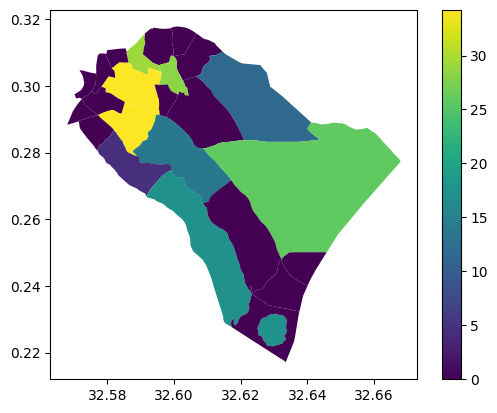

In [69]:
# Convert the DataFrame to a GeoDataFrame
import pandas as pd
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Plot the GeoDataFrame
gdf.plot(column='pm2_5_calibrated_value', legend=True)

# Show the plot
plt.show()

In [70]:
# The predicted values 
gdf

,pname_2010,pm2_5_calibrated_value,hectares,p_02_id,geometry
45,WABIGALO,1.294269e-21,55.924,10210315.0,"POLYGON ((32.60664 0.31582, 32.60640 0.31535, ..."
46,KIBULI,8.487532e-261,102.271,10210306.0,"POLYGON ((32.59892 0.31726, 32.59931 0.31667, ..."
47,KISUGU,0.000000e+00,122.739,10210309.0,"POLYGON ((32.61229 0.31282, 32.61237 0.31261, ..."
48,NSAMBYA POLICE BARRACKS,2.926000e+01,64.106,10210321.0,"POLYGON ((32.59121 0.31563, 32.59133 0.31537, ..."
49,NSAMBYA RAILWAY,5.975822e-218,33.396,10210313.0,"POLYGON ((32.58585 0.31031, 32.58576 0.31011, ..."
50,BUKASA,1.152000e+01,610.936,10210301.0,"POLYGON ((32.62727 0.30468, 32.62726 0.30465, ..."
51,KATWE II,1.294870e-65,50.333,10210305.0,"POLYGON ((32.57944 0.30969, 32.57964 0.30912, ..."
52,KABALAGALA,2.835000e+01,67.697,10210303.0,"POLYGON ((32.60006 0.30890, 32.59995 0.30876, ..."
53,NSAMBYA CENTRAL,3.425000e+01,204.995,10210319.0,"POLYGON ((32.58640 0.30697, 32.58674 0.30676, ..."
54,KATWE I,4.873723e-226,35.397,10210304.0,"POLYGON ((32.57669 0.30366, 32.57669 0.30342, ..."


In [49]:
merged[['pname_2010','pm2_5_calibrated_value',"hectares", "p_02_id",'geometry']]

,pname_2010,pm2_5_calibrated_value,hectares,p_02_id,geometry
45,WABIGALO,NaN,55.924,10210315.0,"POLYGON ((32.60664 0.31582, 32.60640 0.31535, ..."
46,KIBULI,NaN,102.271,10210306.0,"POLYGON ((32.59892 0.31726, 32.59931 0.31667, ..."
47,KISUGU,NaN,122.739,10210309.0,"POLYGON ((32.61229 0.31282, 32.61237 0.31261, ..."
48,NSAMBYA POLICE BARRACKS,29.26,64.106,10210321.0,"POLYGON ((32.59121 0.31563, 32.59133 0.31537, ..."
49,NSAMBYA RAILWAY,NaN,33.396,10210313.0,"POLYGON ((32.58585 0.31031, 32.58576 0.31011, ..."
50,BUKASA,11.52,610.936,10210301.0,"POLYGON ((32.62727 0.30468, 32.62726 0.30465, ..."
51,KATWE II,NaN,50.333,10210305.0,"POLYGON ((32.57944 0.30969, 32.57964 0.30912, ..."
52,KABALAGALA,28.35,67.697,10210303.0,"POLYGON ((32.60006 0.30890, 32.59995 0.30876, ..."
53,NSAMBYA CENTRAL,34.25,204.995,10210319.0,"POLYGON ((32.58640 0.30697, 32.58674 0.30676, ..."
54,KATWE I,NaN,35.397,10210304.0,"POLYGON ((32.57669 0.30366, 32.57669 0.30342, ..."


In [62]:
x_map=gdf.centroid.x.mean()
y_map=gdf.centroid.y.mean()
print(x_map,y_map)

32.601139728156525 0.28494967534784726


<ipython-input-62-b542d65b63d7>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x_map=gdf.centroid.x.mean()
<ipython-input-62-b542d65b63d7>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y_map=gdf.centroid.y.mean()


In [63]:
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.1, 
                                'weight': 0.1}

In [67]:
# Define the style function
# Define the style function

from folium.plugins import MiniMap
def style_function(x):
    value = x['properties']['pm2_5_calibrated_value']
    if value <= 12.1:
        color = '#00E400'  # Good        
    elif value <= 35.4:
        color = '#FFFF00'  # Moderate
    elif value <= 55.4:
        color = '#FF7E00'  # Unhealthy for Sensitive Groups
    elif value <= 150.4:
        color = '#FF0000'  # Unhealthy
    elif value <= 250.4:
        color = '#8F3F97'  # Very Unhealthy
    elif value <= 500:
        color = '#7E0023'  # Hazardous
    else:
        color = '#cccccc'          # No data color grey
    return {
        'fillColor': color,
        'color': '#000000',
        'fillOpacity': 0.9,
        'weight': 0.1
    }
mymap = folium.Map(location=[y_map, x_map], zoom_start=12,tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(mymap)

# Create the GeoJson layer
NIL = folium.features.GeoJson(
    gdf,
    style_function=style_function,
    control=False,
    highlight_function=highlight_function,
    tooltip=folium.features.GeoJsonTooltip(
        fields=['pname_2010', 'pm2_5_calibrated_value' ],
        aliases=['Parish: ', 'PM2.5 value: ' ],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
    )
)


mymap.add_child(NIL)
mymap.keep_in_front(NIL)
folium.LayerControl().add_to(mymap)

minimap = MiniMap()
mymap.add_child(minimap)
mymap